<a href="https://colab.research.google.com/github/nhanlunlk2k/APP-project/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Đồ án môn học**
## Môn: Lập trình song song ứng dụng
### Lớp CQ2021/21 - Nhóm 05
#### Thành viên:
| Họ và tên             | MSSV |
| :-----------          |     :----:|
| Diệp Đại Thiện Nhân | 18120491  |
| Hoàng Trung Nam  | 21120290 |


# **Tổng quan đồ án**

- Nhóm quyết định thử sức với VGG.

- VGG là một kiến trúc CNN sâu được giới thiệu bởi nhóm VGG (Visual Geometry Group) thuộc Đại học Oxford năm 2014. Kiến trúc này nổi bật bởi việc sử dụng nhiều lớp convolution 3x3 liên tiếp thay vì một lớp convolution lớn (vd: 5x5 hay 7x7), nhằm tăng khả năng học đặc trưng và giữ kích thước receptive field ổn định.

- Hai phiên bản phổ biến:
  - VGG-16: 16 lớp có trọng số (13 conv + 3 FC).
  - VGG-19: 19 lớp có trọng số (16 conv + 3 FC).

- **Input của CIFAR-10** là `32x32x3`, nhỏ hơn rất nhiều so với `224x224x3` của VGG gốc.

Vậy nên, khi áp dụng VGG cho CIFAR-10, ta cần **giảm số lượng layer** hoặc **điều chỉnh input size** như sau:

## **Kiến trúc mô hình cụ thể**

- **Input Layer**  
  - 32×32×3 (RGB)

- **Block 1**  
  - Conv3×3, 64 filters + ReLU  
  - Conv3×3, 64 filters + ReLU  
  - MaxPool 2×2

- **Block 2**  
  - Conv3×3, 128 filters + ReLU  
  - Conv3×3, 128 filters + ReLU  
  - MaxPool 2×2

- **Block 3**  
  - Conv3×3, 256 filters + ReLU  
  - Conv3×3, 256 filters + ReLU  
  - MaxPool 2×2

- **Fully Connected**  
  - FC 512 + ReLU  
  - FC 10 + Softmax

- **Optimization**  
  - Loss: Cross‑Entropy  
  - Optimizer: SGD/Adam  
  - Parallelization: Viết bằng Numpy → tối ưu với Numba (`@cuda.jit`)

Kiến trúc VGG‑like này giữ tinh thần “nhiều conv 3×3” của VGG gốc nhưng thu gọn cho phù hợp với kích thước ảnh 32×32 và dataset CIFAR‑10.

## **Dataset**

- **CIFAR-10**:
  - 60.000 ảnh màu 32×32 thuộc 10 lớp.

  - 50.000 ảnh train, 10.000 ảnh test.

  - Link: https://www.cs.toronto.edu/~kriz/cifar.html

## **Nội dung đã hoàn thành**

## **Cài đặt hàm tuần tự**

### **Ý tưởng**

#### 📥 Input Layer

- Kích thước ảnh: **32 × 32 × 3 (RGB)**  
- Sau mỗi layer, kích thước thay đổi tùy theo padding và pooling.

---

#### 🧠 1. Convolutional Layer (3×3)

**Công thức:**

$$
Y[i,j,cout] = \sum_{u=0}^{2} \sum_{v=0}^{2} \sum_{cin=0}^{C_{in}-1} K[u,v,cin,cout] \cdot X[i+u, j+v, cin]
$$

**Chú thích biến:**
- $ X $ : ảnh đầu vào, kích thước (H, W, Cin)
- $K$: kernel/lọc, kích thước (3, 3, Cin, Cout)
- $Y$: ảnh đầu ra sau convolution, kích thước (H', W', Cout)
- $i, j$: vị trí không gian
- $u, v$: tọa độ trong kernel
- $cin, cout$: chỉ số kênh đầu vào và đầu ra

**Song song hóa:**  
✔ Mỗi phần tử $Y[i,j,cout]$ độc lập → triển khai bằng `@cuda.jit` (Numba)

---

#### ⚡ 2. Activation Layer (ReLU)

**Công thức:**

$$
A[i,j,c] = \max(0, Z[i,j,c])
$$

**Chú thích biến:**
- $Z$ : đầu ra từ convolution
- $A$: đầu ra sau kích hoạt ReLU

**Song song hóa:**  
✔ Mỗi phần tử độc lập → dùng `@vectorize` hoặc `@cuda.jit`

---

#### 🌊 3. Max Pooling Layer (2×2)

**Công thức:**

$$
P[i,j,c] = \max \begin{Bmatrix}
X[2i, 2j, c], & X[2i+1, 2j, c], \\
X[2i, 2j+1, c], & X[2i+1, 2j+1, c]
\end{Bmatrix}
$$

**Chú thích biến:**
- $X$: đầu vào trước pooling
- $P$: đầu ra sau pooling
- $i, j$: vị trí trên ảnh pooling
- $c$ : kênh màu

**Song song hóa:**  
✔ Mỗi vùng pooling độc lập → dùng `@cuda.jit`

---

#### 🧩 4. Fully Connected Layer (FC)

**Công thức:**

$$
y_k = \sum_{d=0}^{D-1} W[d,k] \cdot x_d + b_k
$$

**Chú thích biến:**
- $x$: vector đầu vào đã flatten (sau các conv)
- $W$: ma trận trọng số FC (D, K)
- $b$: bias
- $y$: output vector

**Song song hóa:**  
✔ Mỗi $y_k$ độc lập → dùng `@cuda.jit` hoặc `@njit(parallel=True)`

---

#### 🔥 5. Softmax + Cross-Entropy Loss

**Softmax:**

$$
p_i = \frac{e^{y_i}}{\sum_j e^{y_j}}
$$

**Loss:**

$$
L = -\sum_i t_i \cdot \log(p_i)
$$

**Chú thích biến:**
- $y_i$: giá trị đầu ra từ FC
- $p_i$: xác suất sau softmax
- $t_i$: nhãn thật (one-hot)
- $L$: hàm mất mát

**Song song hóa:**  
✘ Không cần, tính nhẹ, có thể xử lý trên CPU

---

#### 🔁 6. Backpropagation + Weight Update

##### Gradient của Softmax + CrossEntropy:

$$
\frac{\partial L}{\partial y_i} = p_i - t_i \quad hay \quad
\frac{\partial L}{\partial y} = p - t
$$

---

##### Gradient của FC:

$$
\frac{\partial L}{\partial W[d,k]} = x_d \cdot \frac{\partial L}{\partial y_k}
\quad ; \quad
\frac{\partial L}{\partial b_k} = \frac{\partial L}{\partial y_k}
$$
hay
$$
\frac{\partial L}{\partial W} = x \cdot \frac{\partial L}{\partial y} \quad ; \quad \frac{\partial L}{\partial b} = \frac{\partial L}{\partial y}
$$

**Song song hóa:** ✔ từng phần tử độc lập → `@cuda.jit`

---

##### Gradient của ReLU:

$$
\frac{\partial L}{\partial Z[i,j,c]} =
\begin{cases}
\frac{\partial L}{\partial A[i,j,c]}, & \text{if } Z[i,j,c] > 0 \\
0, & \text{otherwise}
\end{cases}
$$

---

##### Gradient của Convolution:

$$
\frac{\partial L}{\partial K[u,v,cin,cout]} = \sum_{i,j} \frac{\partial L}{\partial Y[i,j,cout]} \cdot X[i+u,j+v,cin]
$$

$$
\frac{\partial L}{\partial X[i,j,cin]} = \sum_{u,v,cout} \frac{\partial L}{\partial Y[i-u,j-v,cout]} \cdot K[u,v,cin,cout]
$$

**Song song hóa:** ✔ nặng nhất → dùng `@cuda.jit` để tối ưu

---

#### ✅ Tóm tắt khả năng song song hóa

| Lớp              | Cần song song | Ghi chú                                |
|------------------|----------------|----------------------------------------|
| Convolution       | ✅              | Tính toán nặng, phần tử độc lập         |
| ReLU              | ✅              | Mỗi phần tử tính riêng được             |
| Max Pooling       | ✅              | Mỗi vùng pooling độc lập               |
| Fully Connected   | ✅              | Mỗi neuron đầu ra độc lập              |
| Softmax + Loss    | ❌              | Tính nhẹ, xử lý CPU vẫn hiệu quả       |
| Backpropagation   | ✅              | Các đạo hàm có thể tính độc lập        |



### **Chuẩn bị dữ liệu**

In [ ]:
import os
import urllib.request
import tarfile

def download_cifar10():
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    filename = 'cifar-10-python.tar.gz'
    folder = 'cifar-10-batches-py'

    if not os.path.exists(filename):
        print("⏬ Downloading CIFAR-10...")
        urllib.request.urlretrieve(url, filename)

    if not os.path.exists(folder):
        print("📦 Extracting CIFAR-10...")
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
    print("✅ Done.")

download_cifar10()

⏬ Downloading CIFAR-10...
📦 Extracting CIFAR-10...
✅ Done.


In [ ]:
import pickle
import numpy as np

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        images = data[b'data']
        labels = data[b'labels']
        images = images.reshape(-1, 3, 32, 32)  # N x C x H x W
        return images, labels

def load_cifar10_data():
    base_dir = 'cifar-10-batches-py'
    X_train, y_train = [], []

    # Load 5 training batches
    for i in range(1, 6):
        images, labels = load_batch(f'{base_dir}/data_batch_{i}')
        X_train.append(images)
        y_train += labels

    # Load test batch
    X_test, y_test = load_batch(f'{base_dir}/test_batch')

    # Convert to numpy arrays
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar10_data()
print("✅ CIFAR-10 loaded:", X_train.shape, y_train.shape)


✅ CIFAR-10 loaded: (50000, 3, 32, 32) (50000,)


In [ ]:
# Đưa giá trị pixel về [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
print("✅ Normalized CIFAR-10 data:", X_train.shape, y_train.shape)
print("✅ Normalized CIFAR-10 test data:", X_test.shape, y_test.shape)

✅ Normalized CIFAR-10 data: (50000, 3, 32, 32) (50000,)
✅ Normalized CIFAR-10 test data: (10000, 3, 32, 32) (10000,)


In [ ]:
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)
print("✅ One-hot encoded CIFAR-10 labels:", y_train_oh.shape)
print("✅ One-hot encoded CIFAR-10 test labels:", y_test_oh.shape)

✅ One-hot encoded CIFAR-10 labels: (50000, 10)
✅ One-hot encoded CIFAR-10 test labels: (10000, 10)


In [ ]:
# in các ảnh ngẫu nhiên
import matplotlib.pyplot as plt
import random

def show_random_images(X, y, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx].transpose(1, 2, 0))  # Chuyển đổi từ (C, H, W) sang (H, W, C)
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.show()

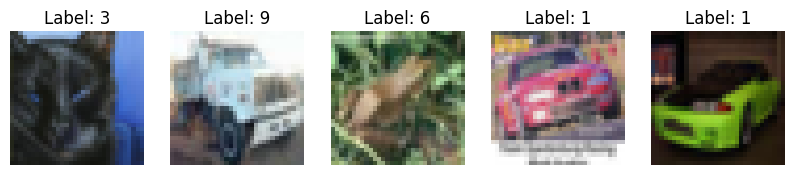

In [ ]:
show_random_images(X_train, y_train)

In [ ]:
# in cây thư mục hiện tại
import os
import json
import datetime
import shutil
import zipfile
import re

def print_directory_tree(path='.'):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

print("📂 Current directory tree:")
print_directory_tree()

📂 Current directory tree:
./
    cifar-10-python.tar.gz
    .config/
        config_sentinel
        default_configs.db
        active_config
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        gce
        .last_update_check.json
        .last_survey_prompt.yaml
        .last_opt_in_prompt.yaml
        configurations/
            config_default
        logs/
            2025.04.24/
                18.19.38.522066.log
                18.19.17.922226.log
                18.19.48.089267.log
                18.19.56.709493.log
                18.19.46.929623.log
                18.19.57.353004.log
    cifar-10-batches-py/
        batches.meta
        data_batch_5
        data_batch_4
        data_batch_2
        test_batch
        readme.html
        data_batch_3
        data_batch_1
    sample_data/
        anscombe.json
        README.md
        mnist_test.csv
        mnist_train_small.csv
        california_housing_train.csv
        california_housing_test.csv

### **Hàm conv2d()**

In [ ]:
def conv2d(X, K, stride=1, padding=1):
    """
    X: Input image, shape (C_in, H, W)
    K: Filter weights, shape (C_out, C_in, kH, kW)
    stride: bước di chuyển
    padding: số pixel pad xung quanh ảnh

    Trả về: Feature map, shape (C_out, H_out, W_out)
    """
    C_in, H, W = X.shape
    C_out, _, kH, kW = K.shape

    # Pad input nếu cần
    if padding > 0:
        X_padded = np.pad(X, ((0,0), (padding,padding), (padding,padding)), mode='constant')
    else:
        X_padded = X

    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1
    Y = np.zeros((C_out, H_out, W_out), dtype=np.float32)

    for cout in range(C_out):
        for i in range(H_out):
            for j in range(W_out):
                for cin in range(C_in):
                    h_start = i * stride
                    w_start = j * stride
                    region = X_padded[cin, h_start:h_start+kH, w_start:w_start+kW]
                    Y[cout, i, j] += np.sum(region * K[cout, cin])

    return Y

In [ ]:
# Test hàm conv2d
X = np.random.rand(3, 32, 32)         # Input: 3 channels (RGB), 32x32
K = np.random.rand(64, 3, 3, 3)       # 64 filters, mỗi filter 3x3x3

out = conv2d(X, K, stride=1, padding=1)
print("✅ Conv2D output:", out.shape)  # Kết quả: (64, 32, 32)

In [ ]:
# %pip install numba

In [ ]:
from numba import njit

@njit
def pad2d_manual(X, pad):
    C, H, W = X.shape
    X_padded = np.zeros((C, H + 2*pad, W + 2*pad), dtype=X.dtype)
    for c in range(C):
        for i in range(H):
            for j in range(W):
                X_padded[c, i + pad, j + pad] = X[c, i, j]
    return X_padded


In [ ]:
@njit  # không dùng parallel để đảm bảo logic tuần tự
def conv2d_fast(X, K, stride=1, padding=1):
    C_in, H, W = X.shape
    C_out, _, kH, kW = K.shape

    if padding > 0:
        X_padded = pad2d_manual(X, padding)
    else:
        X_padded = X

    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1
    Y = np.zeros((C_out, H_out, W_out), dtype=np.float32)

    for cout in range(C_out):
        for i in range(H_out):
            for j in range(W_out):
                for cin in range(C_in):
                    for u in range(kH):
                        for v in range(kW):
                            Y[cout, i, j] += X_padded[cin, i*stride + u, j*stride + v] * K[cout, cin, u, v]
    return Y


### **Hàm ReLU**

In [ ]:
def relu(X):
    return np.maximum(0, X)

### **Max Pooling 2x2**

In [ ]:
def max_pool2x2(X):
    """
    X: Input feature map, shape (C, H, W)
    Returns: Downsampled feature map, shape (C, H//2, W//2)
    """
    C, H, W = X.shape
    out_H, out_W = H // 2, W // 2
    pooled = np.zeros((C, out_H, out_W), dtype=np.float32)

    for c in range(C):
        for i in range(out_H):
            for j in range(out_W):
                region = X[c, i*2:i*2+2, j*2:j*2+2]
                pooled[c, i, j] = np.max(region)
    return pooled

### **Block 1 + 2 + 3**

In [ ]:
%%time
# Khởi tạo ngẫu nhiên các filter Conv
np.random.seed(42)
K1 = np.random.randn(64, 3, 3, 3) * 0.1  # 64 filters, 3x3, input 3 channels
K2 = np.random.randn(64, 64, 3, 3) * 0.1  # 64 filters, 3x3, input 64 channels

def block1(X):
    out = conv2d(X, K1, stride=1, padding=1)
    out = relu(out)
    out = conv2d(out, K2, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out

# Thử với ảnh đầu tiên
out_block1 = block1(X_train[0])
print("✅ Output Block 1:", out_block1.shape)


In [ ]:
# Khởi tạo ngẫu nhiên các filter Conv
# Block 1
np.random.seed(42)
K1 = np.random.randn(64, 3, 3, 3) * 0.1  # 64 filters, 3x3, input 3 channels
K2 = np.random.randn(64, 64, 3, 3) * 0.1  # 64 filters, 3x3, input 64 channels

# Block 2
K3 = np.random.randn(128, 64, 3, 3) * 0.1  # 128 filters, 3x3, input 64 channels
K4 = np.random.randn(128, 128, 3, 3) * 0.1  # 128 filters, 3x3, input 128 channels

# Block 3
K5 = np.random.randn(256, 128, 3, 3) * 0.1  # 256 filters, 3x3, input 128 channels
K6 = np.random.randn(256, 256, 3, 3) * 0.1  # 256 filters, 3x3, input 256 channels

def block1_fast(X):
    out = conv2d_fast(X, K1, stride=1, padding=1)
    out = relu(out)
    out = conv2d_fast(out, K2, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out

def block2_fast(X):
    out = conv2d_fast(X, K3, stride=1, padding=1)
    out = relu(out)
    out = conv2d_fast(out, K4, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out

def block3_fast(X):
    out = conv2d_fast(X, K5, stride=1, padding=1)
    out = relu(out)
    out = conv2d_fast(out, K6, stride=1, padding=1)
    out = relu(out)
    out = max_pool2x2(out)
    return out


In [ ]:
%%time
# Thử với ảnh đầu tiên
out_block1_fast = block1_fast(X_train[0])
print("✅ Output Block 1 (fast):", out_block1_fast.shape)
out_block2_fast = block2_fast(out_block1_fast)
print("✅ Output Block 2 (fast):", out_block2_fast.shape)
out_block3_fast = block3_fast(out_block2_fast)
print("✅ Output Block 3 (fast):", out_block3_fast.shape)

In [ ]:
# Flatten: (256, 4, 4) → 256*4*4 = 4096 đầu vào
W1 = np.random.randn(512, 256 * 4 * 4) * 0.1  # FC: 4096 → 512
b1 = np.zeros((512,))

W2 = np.random.randn(10, 512) * 0.1  # FC: 512 → 10
b2 = np.zeros((10,))

In [ ]:
def fc_forward(X, W, b):
    return np.dot(W, X) + b

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Tránh overflow
    return e_x / np.sum(e_x)


In [ ]:
def forward(X):
    out = block1_fast(X)
    out = block2_fast(out)
    out = block3_fast(out)

    out = out.reshape(-1)  # Flatten: (256,4,4) -> (4096,)

    out = fc_forward(out, W1, b1)
    out = relu(out)

    out = fc_forward(out, W2, b2)
    out = softmax(out)

    return out


In [ ]:
%%time
# Thử với ảnh đầu tiên
out = forward(X_train[0])
print("✅ Output of the network:", out.shape)
print("✅ Predicted class:", np.argmax(out))
print("✅ True class:", y_train[0])


In [ ]:
def cross_entropy_loss(y_pred, y_true):
    return -np.log(y_pred[y_true] + 1e-9)  # Tránh log(0)

def accuracy(y_pred, y_true):
    return int(np.argmax(y_pred) == y_true)


In [ ]:
def softmax_gradient(y_pred, y_true):
    return softmax(y_pred) - y_true

def gradient_weights(X,y,y_true):
    return X.T @ softmax_gradient(y,y_true)

def gradient_ReLU(X,y,y_true):
    A = X
    A[A < 0] = 0
    A[A > 0] = 1
    return A * softmax_gradient(y,y_true)

def gradient_Convolution(X,y,y_true):
    pass

def gradient_descent(W, b, grad_W, grad_b, learning_rate):
    pass

In [ ]:
y_pred = forward(X_train[0])
loss = cross_entropy_loss(y_pred, y_train[0])
acc = accuracy(y_pred, y_train[0])

print("📉 Loss:", loss)
print("🎯 Accuracy:", acc)
